In [1]:
    import wandb
    wandb.login()

wandb: Currently logged in as: elijahkamski (cyberlife). Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np

In [3]:
!ls /media/elijah/T7/ds000117-download

acq-mprage_T1w.json	  stimuli
annex-uuid		  sub-01
CHANGES			  sub-02
dataset_description.json  sub-03
derivatives		  sub-04
participants.tsv	  sub-05
README			  sub-06
run-1_echo-1_FLASH.json   sub-07
run-1_echo-2_FLASH.json   sub-08
run-1_echo-3_FLASH.json   sub-09
run-1_echo-4_FLASH.json   sub-10
run-1_echo-5_FLASH.json   sub-11
run-1_echo-6_FLASH.json   sub-12
run-1_echo-7_FLASH.json   sub-13
run-2_echo-1_FLASH.json   sub-14
run-2_echo-2_FLASH.json   sub-15
run-2_echo-3_FLASH.json   sub-16
run-2_echo-4_FLASH.json   sub-emptyroom
run-2_echo-5_FLASH.json   task-facerecognition_beh.json
run-2_echo-6_FLASH.json   task-facerecognition_bold.json
run-2_echo-7_FLASH.json


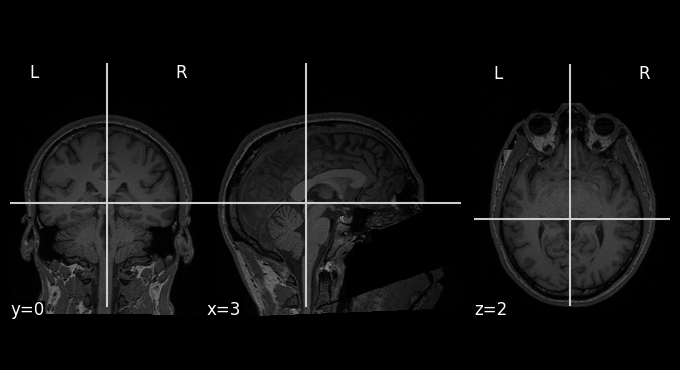

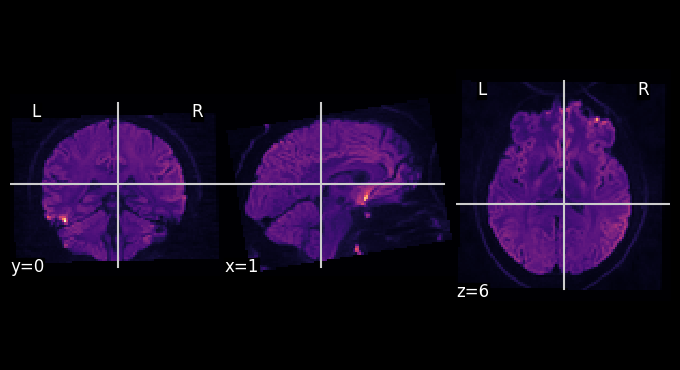

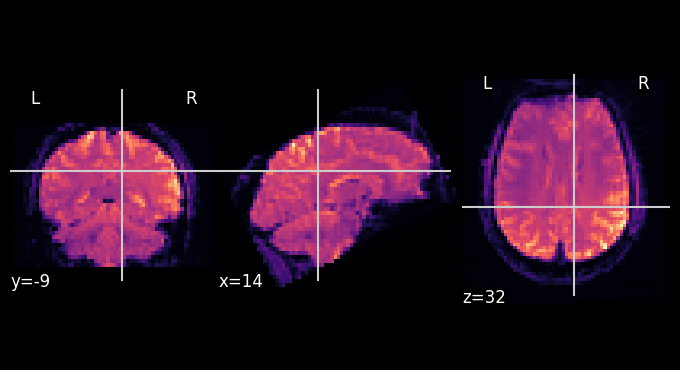

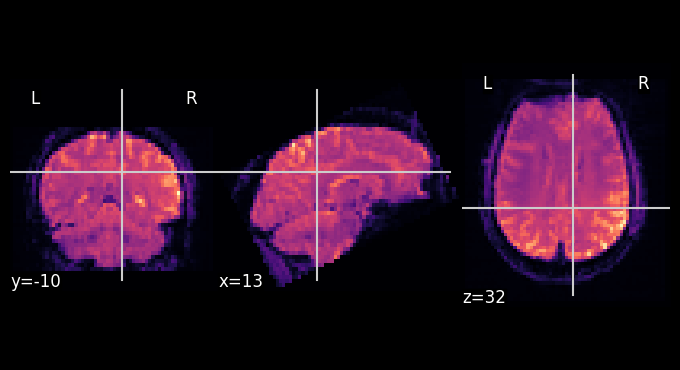

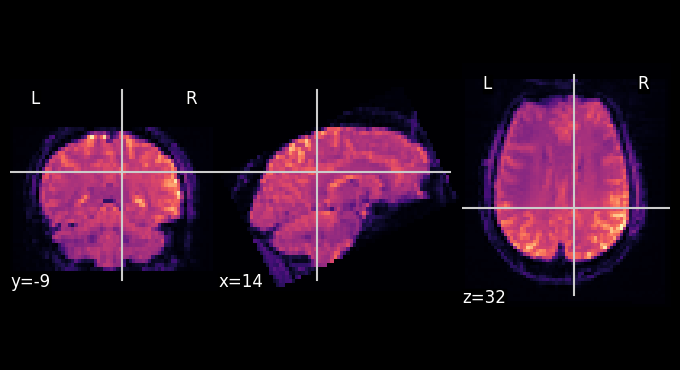

In [4]:
import os
from bids import BIDSLayout
from nilearn import plotting, image
import nibabel as nib

# Указываем путь к BIDS датасету
bids_path = "/media/elijah/T7/ds000117-download"

# Инициализируем BIDS Layout
layout = BIDSLayout(bids_path)

# Получаем список всех NIfTI файлов в датасете
nifti_files = layout.get(extension='nii.gz', return_type='file')

# Визуализируем каждый NIfTI файл
for nifti_file in nifti_files[:5]:
    # Load the nifti file using nibabel
    img = nib.load(nifti_file)
    
    # Check if the image is 4D (e.g., fMRI data)
    if len(img.shape) == 4:
        func_image_mean = image.mean_img(img)
        plotting.plot_epi(func_image_mean, cmap='magma')
    else:
        plotting.plot_anat(img)

    plotting.show()


In [5]:
img = nib.load(nifti_file)

In [6]:
img.get_fdata().shape

(64, 64, 33, 208)

/home/elijah/.cache/pypoetry/virtualenvs/eeg-mri-analyzer-C0pNHHSC-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/elijah/.cache/pypoetry/virtualenvs/eeg-mri-analyzer-C0pNHHSC-py3.10/lib/python3.10/site-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")



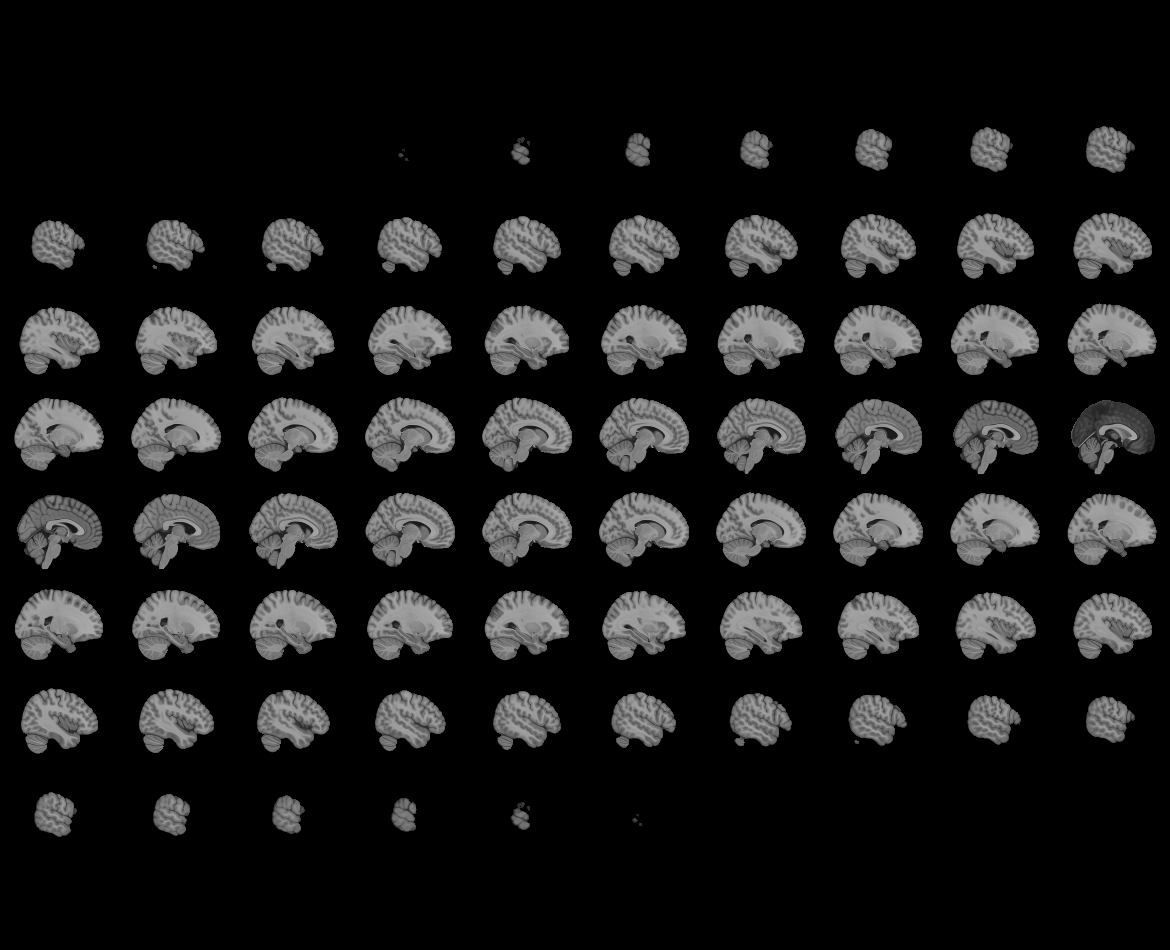
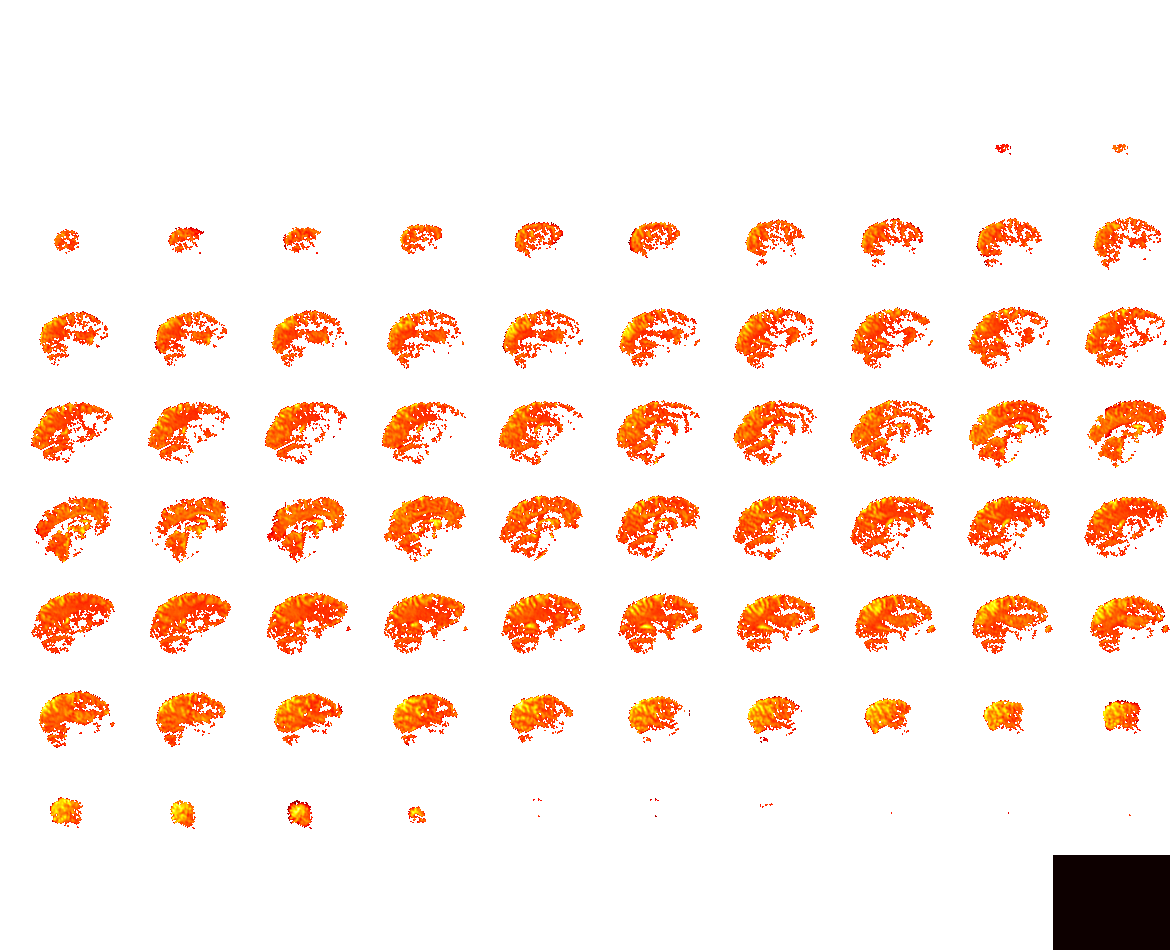

In [7]:
plotting.view_img(img.slicer[...,0], threshold='auto',
                  cmap='cold_hot', )

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

In [9]:
from streaming import StreamingDataset, StreamingDataLoader
output_path='/media/elijah/T7/ds000117-mri-streaming/'
batch_size = 1
dataset = StreamingDataset(local=output_path, batch_size=batch_size)
loader = StreamingDataLoader(dataset,batch_size=batch_size)

Because `predownload` was not specified, it will default to 8*batch_size if batch_size is not None, otherwise 64. Prior to Streaming v0.7.0, `predownload` defaulted to max(batch_size, 256 * batch_size // num_canonical_nodes).


In [10]:
a = next(iter(loader))

Because `num_canonical_nodes` was not specified, and `shuffle_algo` is py1e, it will default to be equal to physical nodes. Prior to Streaming v0.7.0, `num_canonical_nodes` defaulted to 64 * physical nodes.
Because `shuffle_block_size` was not specified, it will default to max(4_000_000 // num_canonical_nodes, 1 << 18) if num_canonical_nodes is not None, otherwise 262144. Prior to Streaming v0.7.0, `shuffle_block_size` defaulted to 262144.
/home/elijah/.cache/pypoetry/virtualenvs/eeg-mri-analyzer-C0pNHHSC-py3.10/lib/python3.10/site-packages/streaming/base/dataset.py:898: RuntimeWarning: divide by zero encountered in scalar floor_divide
  shard_shuffle_units = [shard_samples] * (shard_choose // shard_samples)
/home/elijah/.cache/pypoetry/virtualenvs/eeg-mri-analyzer-C0pNHHSC-py3.10/lib/python3.10/site-packages/streaming/base/dataset.py:899: RuntimeWarning: divide by zero encountered in scalar remainder
  remainder = shard_choose % shard_samples
/home/elijah/.cache/pypoetry/virtualenvs/e

In [11]:
a['func'].shape

torch.Size([1, 64, 64, 33, 128])

In [12]:
a['label'].shape

torch.Size([1, 128])

In [13]:
a.keys()

dict_keys(['affine', 'func', 'label', 'subject'])

In [42]:
import torch
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics
# from torch.cuda.amp import autocast, GradScaler

class FMRIVolumeClassifier(pl.LightningModule):
    def __init__(self, num_subjects, d_model=512, num_classes=10, input_shape=(1, 64, 64, 33)):
        super().__init__()
        self.save_hyperparameters()
        # self.scaler = GradScaler()

        # self.embedding = nn.Embedding(num_embeddings=num_subjects, embedding_dim=d_model)
        
        self.conv3d = nn.Sequential(
            nn.Conv3d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2),
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2),
            nn.BatchNorm3d(64),
        )
        
        conv3d_output_size = self._get_conv3d_output_size(input_shape)
        self.fc_input_size = conv3d_output_size * 64
        
        self.encoder = nn.Sequential(
            nn.Linear(self.fc_input_size, d_model),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
        )
        
        self.lstm = nn.LSTM(d_model, d_model, batch_first=True)
        # Or use TransformerEncoder
        # self.transformer_encoder = nn.TransformerEncoder(
        #     nn.TransformerEncoderLayer(d_model=d_model, nhead=8),
        #     num_layers=6
        # )
        
        self.classifier = nn.Linear(d_model, num_classes)
        
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

    def _get_conv3d_output_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.conv3d(dummy_input)
            return torch.tensor(output.shape[2:]).prod().item()

    def forward(self, x, subject_id):
        x = x.view(x.shape[0], x.shape[4], 1, x.shape[1], x.shape[2], x.shape[3])
        # print(x.size())
        batch_size, seq_len, _, _, _, _ = x.size()
        x = x.view(batch_size * seq_len, *x.size()[2:])
        x = self.conv3d(x)
        x = x.view(batch_size, seq_len, -1)
        x = self.encoder(x)

        # emb = self.embedding(subject_id).unsqueeze(1).repeat(1, seq_len, 1)
        # x = x + emb

        x, _ = self.lstm(x)
        # Or use TransformerEncoder
        # x = self.transformer_encoder(x.permute(1, 0, 2)).permute(1, 0, 2)
        
        logits = self.classifier(x)
        return logits

    def training_step(self, batch, batch_idx):
        x = batch['func']
        y = batch['label'].long()
        subject_id = batch['subject']
        logits = self.forward(x, subject_id)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        acc = self.accuracy(logits.view(-1, logits.size(-1)), y.view(-1))
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch['func']
        y = batch['label']
        subject_id = batch['subject']
        logits = self.forward(x, subject_id)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        acc = self.accuracy(logits.view(-1, logits.size(-1)), y.view(-1))
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
        return [optimizer], [scheduler]

In [43]:
version = 0

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [46]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Thu May 23 03:31:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 30%   53C    P2    48W / 220W |   1960MiB /  8192MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
version+=1
n_classes = 4
model = FMRIVolumeClassifier(num_classes=n_classes,
                               num_subjects=17,
                               d_model=128,
                              )

In [48]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
# default logger used by trainer (if tensorboard is installed)
logger = WandbLogger(project='diploma', name='diploma_fmri_LSTM3dConv',)
# Initialize a trainer
trainer = Trainer(max_epochs=90,
                  gradient_clip_val=0.7,
                  log_every_n_steps=1,
                  default_root_dir="my_checkopoints/fmri_3d_conv/",
                  enable_checkpointing=True,
                  precision='16-mixed',
                  detect_anomaly=True,
                  # accelerator='cpu',
                  accumulate_grad_batches=8)  # Adjust max_epochs as needed, set gpus=0 for CPU

# Train the model
    

Using 16bit Automatic Mixed Precision (AMP)
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [49]:
trainer.fit(model, loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | conv3d     | Sequential         | 56.4 K
1 | encoder    | Sequential         | 16.8 M
2 | lstm       | LSTM               | 132 K 
3 | classifier | Linear             | 516   
4 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
17.0 M    Trainable params
0         Non-trainable params
17.0 M    Total params
67.866    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=90` reached.


In [22]:
torch.save(model.state_dict(), 'model_conv3d_V1_0687.pt')

In [23]:
shift = 3

dataset = FMRIEventsDataset(layout, layout.get_tr(), time_shift=shift, preprocess=True, augmentation=False)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=11)
version+=1
n_classes = len(dataset.unique_labels)


model = FMRIVolumeClassifier(num_classes=n_classes,
                               num_subjects=len(dataset.subject_id_to_int),
                               d_model=128,
                              )


NameError: name 'FMRIEventsDataset' is not defined

In [ ]:
model.load_state_dict(torch.load('model_conv3d_V1_0687.pt'))

In [ ]:
batch = next(iter(train_loader))

In [ ]:
# !pip install shap

In [ ]:
class ModelWrapper(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.original_model = original_model
    
    def forward(self, combined_input):
        # Assuming the last dimension is used to store subject_id which is appended to fmri_data
        fmri_data = combined_input[:, :-1].reshape(len(combined_input), 1, 40, 64, 64)
        subject_id = combined_input[:, -1].long() # Adjust slicing as needed
        return self.original_model(fmri_data, subject_id)

wrapper = ModelWrapper(model).cuda()


data_comb = torch.stack([torch.cat((batch[0][i].reshape(-1), torch.as_tensor([batch[2][i]])))  for i in range(len(batch[0]))]).cuda()
data_comb_interpret = torch.stack([torch.cat((batch[0][i].reshape(-1), torch.as_tensor([batch[2][i]])))  for i in range(len(batch[0]))]).cuda()


from shap import DeepExplainer

explainer = DeepExplainer(wrapper, data_comb)

shap_values = explainer.shap_values(data_comb_interpret, check_additivity=False)

In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting
import gradio as gr

def visualize_brain(subject, class_name):
    
    # Assuming batch, shap_values, and other data variables are already loaded and accessible
    class_idx = dataset.label_encoder.transform([class_name])[0]
    # Example data processing
    subj_image = batch[0][subject].reshape(40, 64, 64).numpy()
    subj_affine = batch[3][subject]

    shap_as_inp = shap_values[subject, :-1, ...].reshape(163840, 8)[..., class_idx]
    shap_values_for_class = shap_as_inp.reshape(40, 64, 64)
    sub_num = str(batch[2][subject].long().item())
    print(sub_num , type(sub_num))
    bg_nifti_img = nib.load(dataset.anatomics[sub_num])
    shap_nifti_img = nib.Nifti1Image(shap_values_for_class, subj_affine)

    view = plotting.view_img(shap_nifti_img, threshold='auto', bg_img=bg_nifti_img, cmap='cold_hot')

    # Get the HTML code from the viewer object
    html_view = view.get_iframe()  # or view.get_html() depending on nilearn version
    return html_view



In [ ]:
mapping = '\n'.join([f"{i}:{label}"for i, label in enumerate(dataset.label_encoder.classes_)])
info = f"Class mapping:\n {mapping}"
subject_slider = gr.Slider(minimum=0, maximum=len(batch[0]), step=1, label="Subject Number")  # Adjust the range as necessary
class_picker = gr.Dropdown(dataset.label_encoder.classes_.tolist())
# class_slider = gr.Slider(minimum=0, maximum=n_classes, step=1, label="Class Index", info=info)  # Adjust the range as necessary

iface = gr.Interface(fn=visualize_brain, 
                     inputs=[subject_slider, class_picker], 
                     outputs="html",
                     live=True)

iface.launch(share=True,)


In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import imageio
import os
from nilearn.image import resample_to_img

nifti_img = nib.Nifti1Image(shap_values_abs,
                                 subj_affine)
background_img = nib.load(dataset.anatomics[id_to_sub[batch[2][subject].long().item()]])


axis = 2  # 0 for sagittal, 1 for coronal, 2 for axial
skip = 2  # Number of slices to skip
color_map = 'cold_hot'  # Color map for the slice images
background_color_map = 'gray'  # Color map for the background image
lower_percentile = 5   # Lower percentile threshold
upper_percentile = 95  # Upper percentile threshold

# Function to resample a slice to match another's affine
def resample_to_affine(source_img, target_img):
    return resample_to_img(source_img, target_img)

# Adjusted save_slice to consider affine alignment and apply two-sided percentile threshold
def save_slice(slice_data, background_slice, index, colormap='gray'):
    fig, ax = plt.subplots(figsize=(5, 5))
    if background_slice is not None:
        ax.imshow(background_slice.T, cmap=background_color_map, origin='lower', interpolation='none')
    
    # Apply a two-sided percentile-based mask to the slice data
    lower_threshold = np.percentile(slice_data, lower_percentile)
    upper_threshold = np.percentile(slice_data, upper_percentile)
    masked_data = np.ma.masked_outside(slice_data, lower_threshold, upper_threshold)

    ax.imshow(masked_data.T, cmap=colormap, origin='lower', interpolation='none', alpha=0.7)  # Change alpha for transparency
    ax.axis('off')
    plt.savefig(f'slice_{index}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

# Resample background image to the main image's space if provided
if background_img is not None:
    resampled_background_img = resample_to_affine(background_img, nifti_img)
    background_data = resampled_background_img.get_fdata()
else:
    background_data = None

# Extract and save slices
data = nifti_img.get_fdata()
slices = range(0, data.shape[axis], skip)

for i in slices:
    slice_data = data.take(indices=i, axis=axis)
    background_slice = background_data.take(indices=i, axis=axis) if background_data is not None else None
    save_slice(slice_data, background_slice, i, colormap=color_map)

# Create the GIF
images = [imageio.imread(f'slice_{i}.png') for i in slices]
imageio.mimsave('brain_slices.gif', images, duration=0.3)  # Adjust the frame duration as needed

# Clean up the generated images
for i in slices:
    os.remove(f'slice_{i}.png')

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting

subject = 10
time = 0
class_index = 1


subj_image = batch[0][subject].reshape(40, 64, 64).numpy()
subj_affine = batch[3][subject]
# subj_affine = np.eye(4)

shap_as_inp = shap_values[subject-10, :-1,...].reshape(163840, 8)[...,0]
shap_values_for_class = shap_as_inp.reshape(40, 64, 64)

bg_nifti_img = nib.load(dataset.anatomics[id_to_sub[batch[2][subject].long().item()]])

# Convert SHAP values to an absolute value to focus on magnitude of impact
shap_values_abs = shap_values_for_class

# Since we want to display these values interactively, let's aggregate them across the depth dimension
# shap_values_aggregated = np.mean(shap_values_abs, axis=0)

# Create a NIfTI-like object; you might need to adjust the affine transformation based on your data specifics
shap_nifti_img = nib.Nifti1Image(shap_values_abs,
                                 subj_affine)


# Display the image interactively
# Adjust the threshold as necessary to highlight the most significant contributions
plotting.view_img(shap_nifti_img, threshold='auto',
                  bg_img=bg_nifti_img,
                  title=f'SHAP values for class {class_index}',
                  cmap='cold_hot', )